## We find differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression

In [31]:
import os
import pandas
from definitions import ROOT_DIR

mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))

print "mirna_tumor_df.shape", mirna_tumor_df.shape, ', nulls:', mirna_tumor_df.isnull().sum().sum()
print "mirna_normal_df.shape", mirna_normal_df.shape, ', nulls:', mirna_normal_df.isnull().sum().sum()
print 'validated_miRNAs.shape', validated_miRNA_csv.shape
 
X_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
X_normal['pathologic_stage'] = 'normal'
X_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}

X_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

print X_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print X_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882) , nulls: 0
mirna_normal_df.shape (46, 1882) , nulls: 0
validated_miRNAs.shape (34, 2)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## We now create data matrixes from tumor vs normal samples

- We do not normalize the miRNA expression values because we are using Read Per Kilobase Million Mapped

In [32]:
X = pandas.concat([X_normal, X_tumor]).dropna(subset=['pathologic_stage'])
Y = X['pathologic_stage']

X_normal_vs_I = X[X['pathologic_stage'].isin(['normal', 'Stage I'])]
X_normal_vs_II = X[X['pathologic_stage'].isin(['normal', 'Stage II'])]
X_normal_vs_III = X[X['pathologic_stage'].isin(['normal', 'Stage III'])]
X_normal_vs_IV = X[X['pathologic_stage'].isin(['normal', 'Stage IV'])]

Y_normal_vs_I = X_normal_vs_I['pathologic_stage']
Y_normal_vs_II = X_normal_vs_II['pathologic_stage']
Y_normal_vs_III = X_normal_vs_III['pathologic_stage']
Y_normal_vs_IV = X_normal_vs_IV['pathologic_stage']

X_normal_vs_I.__delitem__('patient_barcode')
X_normal_vs_I.__delitem__('pathologic_stage')
X_normal_vs_II.__delitem__('patient_barcode')
X_normal_vs_II.__delitem__('pathologic_stage')
X_normal_vs_III.__delitem__('patient_barcode')
X_normal_vs_III.__delitem__('pathologic_stage')
X_normal_vs_IV.__delitem__('patient_barcode')
X_normal_vs_IV.__delitem__('pathologic_stage')

X.__delitem__('patient_barcode')
X.__delitem__('pathologic_stage')

print 'miRNA null values', X.isnull().sum().sum()
print 'Y null values', Y.isnull().sum()

print "X.shape", X.shape
print "Y.shape", Y.shape

mirna_list = X.columns.values
validated_miRNAs = set(validated_miRNA_csv['miRNA'].tolist())

miRNA null values 0
Y null values 0
X.shape (552, 1881)
Y.shape (552,)


In [33]:
print "mirna_list", len(mirna_list)
print 'validated_miRNAs', len(validated_miRNAs)

print "number of validated miRNAs in list of all miRNAs", len(validated_miRNAs & set(mirna_list))

print Y_normal_vs_I.value_counts()
print Y_normal_vs_II.value_counts()
print Y_normal_vs_III.value_counts()
print Y_normal_vs_IV.value_counts()

mirna_list 1881
validated_miRNAs 27
number of validated miRNAs in list of all miRNAs 21
Stage I    277
normal      46
Name: pathologic_stage, dtype: int64
Stage II    121
normal       46
Name: pathologic_stage, dtype: int64
Stage III    84
normal       46
Name: pathologic_stage, dtype: int64
normal      46
Stage IV    24
Name: pathologic_stage, dtype: int64


## Perform classification for normal vs Stage I, Stage II, Stage III, and Stage IV


In [50]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import numpy as np

X_normal_vs_I_train, X_normal_vs_I_test, Y_normal_vs_I_train, Y_normal_vs_I_test = \
    train_test_split(X_normal_vs_I, Y_normal_vs_I, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_II_train, X_normal_vs_II_test, Y_normal_vs_II_train, Y_normal_vs_II_test = \
    train_test_split(X_normal_vs_II, Y_normal_vs_II, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_III_train, X_normal_vs_III_test, Y_normal_vs_III_train, Y_normal_vs_III_test = \
    train_test_split(X_normal_vs_III, Y_normal_vs_III, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_IV_train, X_normal_vs_IV_test, Y_normal_vs_IV_train, Y_normal_vs_IV_test = \
    train_test_split(X_normal_vs_IV, Y_normal_vs_IV, test_size=0.2, random_state=np.random.randint(0, 10000))


normal_vs_I =   linear_model.LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-3, 7))),
                                                solver='liblinear',
                                                penalty='l1', fit_intercept=False)
normal_vs_II =  linear_model.LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-3, 7))),
                                                 solver='liblinear',
                                                 penalty='l1', fit_intercept=False)
normal_vs_III = linear_model.LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-3, 7))),
                                                  solver='liblinear',
                                                  penalty='l1', fit_intercept=False)
normal_vs_IV =  linear_model.LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-3, 7))),
                                                 solver='liblinear',
                                                 penalty='l1', fit_intercept=False)
print normal_vs_I.fit(X_normal_vs_I_train, Y_normal_vs_I_train)
print normal_vs_II.fit(X_normal_vs_II_train, Y_normal_vs_II_train)
print normal_vs_III.fit(X_normal_vs_III_train, Y_normal_vs_III_train)
print normal_vs_IV.fit(X_normal_vs_IV_train, Y_normal_vs_IV_train)

# print "\nClassification_report on training"
# print metrics.classification_report(y_train, model.predict(X_train), 
#                                     labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
#                                     target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])
# print "classification_report on testing"
# print metrics.classification_report(y_test, model.predict(X_test), 
#                                     labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
#                                     target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])
# print metrics.confusion_matrix(y_test, model.predict(X_test), 
#                                labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])

LogisticRegressionCV(Cs=[0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
           class_weight=None, cv=None, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)


LogisticRegressionCV(Cs=[0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
           class_weight=None, cv=None, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)


LogisticRegressionCV(Cs=[0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
           class_weight=None, cv=None, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)
LogisticRegressionCV(Cs=[0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
           class_weight=None, cv=None, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)


## Show number of candidate miRNAs, top miRNA's based on coefficient, and percentage of known miRNA

In [51]:
from src.utils.validate_candidate_miRNAs import percent_candidate_in_validated
results = []

for model, name in zip([normal_vs_I, normal_vs_II, normal_vs_III, normal_vs_IV], 
                       ['normal_vs_I', 'normal_vs_II', 'normal_vs_III', 'normal_vs_IV']):
    print '\n', name 
    non_zero_idx = np.nonzero(model.coef_.ravel())[0]
    print "Non-zero coef:", non_zero_idx.size
    df = pandas.DataFrame({"mirna": mirna_list[non_zero_idx],
                           "coefficient": model.coef_.ravel()[non_zero_idx]})
    print df.sort_values(by='coefficient', ascending=False).head(6)
    print df.sort_values(by='coefficient', ascending=True).head(6)
    
    print "Percentage of known NSCLC miRNAs:", percent_candidate_in_validated(df['mirna'].tolist(), validated_miRNAs)
    print set(df['mirna'].tolist()) & validated_miRNAs, len(set(df['mirna'].tolist()) & validated_miRNAs)
    
    results.append(df)


normal_vs_I
Non-zero coef: 19
    coefficient           mirna
16     0.000188     hsa-mir-30a
6      0.000143  hsa-mir-103a-1
7      0.000134  hsa-mir-103a-2
12     0.000125    hsa-mir-200c
4      0.000037    hsa-let-7f-2
8      0.000028     hsa-mir-143
    coefficient         mirna
10    -0.000601   hsa-mir-182
9     -0.000305  hsa-mir-148a
17    -0.000236   hsa-mir-30d
15    -0.000188    hsa-mir-22
13    -0.000037  hsa-mir-203a
11    -0.000010   hsa-mir-192
Percentage of known NSCLC miRNAs: 0.0740740740741
set(['hsa-mir-200c', 'hsa-mir-30a']) 2

normal_vs_II
Non-zero coef: 208
     coefficient           mirna
185     0.049878     hsa-mir-598
138     0.020687     hsa-mir-340
165     0.017394    hsa-mir-4772
35      0.016802  hsa-mir-133a-2
97      0.016148   hsa-mir-218-1
149     0.014156    hsa-mir-374b
     coefficient           mirna
160    -0.035235    hsa-mir-450b
179    -0.023384    hsa-mir-5698
103    -0.019050     hsa-mir-224
163    -0.017893     hsa-mir-454
78     -0.013887 

In [52]:
for i in range(len(results)):
    for j in range(len(results)):
        print '\n', "Stage "+str(i+1)+' - Stage '+str(j+1), ' : ',len(set(results[i]['mirna'].tolist()) & set(results[j]['mirna'].tolist()))
        # print set(results[i]['mirna'].tolist()) & set(results[j]['mirna'].tolist())


Stage 1 - Stage 1  :  19

Stage 1 - Stage 2  :  19

Stage 1 - Stage 3  :  19

Stage 1 - Stage 4  :  18

Stage 2 - Stage 1  :  19

Stage 2 - Stage 2  :  208

Stage 2 - Stage 3  :  58

Stage 2 - Stage 4  :  59

Stage 3 - Stage 1  :  19

Stage 3 - Stage 2  :  58

Stage 3 - Stage 3  :  58

Stage 3 - Stage 4  :  47

Stage 4 - Stage 1  :  18

Stage 4 - Stage 2  :  59

Stage 4 - Stage 3  :  47

Stage 4 - Stage 4  :  59


In [53]:
# print normal_vs_I.fit(X_normal_vs_I, Y_normal_vs_I)
# print normal_vs_II.fit(X_normal_vs_II, Y_normal_vs_II)
# print normal_vs_III.fit(X_normal_vs_III, Y_normal_vs_III)
# print normal_vs_IV.fit(X_normal_vs_IV, Y_normal_vs_IV)

print metrics.classification_report(Y_normal_vs_I_test, normal_vs_I.predict(X_normal_vs_I_test), 
                                    labels=['normal', 'Stage I'], 
                                    target_names=['normal', 'Stage I']) 
print metrics.classification_report(Y_normal_vs_II_test, normal_vs_II.predict(X_normal_vs_II_test), 
                                    labels=['normal', 'Stage II'], 
                                    target_names=['normal', 'Stage II']) 
print metrics.classification_report(Y_normal_vs_III_test, normal_vs_III.predict(X_normal_vs_III_test), 
                                    labels=['normal', 'Stage III'], 
                                    target_names=['normal', 'Stage III']) 
print metrics.classification_report(Y_normal_vs_IV_test, normal_vs_IV.predict(X_normal_vs_IV_test), 
                                    labels=['normal', 'Stage IV'], 
                                    target_names=['normal', 'Stage IV'])

             precision    recall  f1-score   support

     normal       0.91      1.00      0.95        10
    Stage I       1.00      0.98      0.99        55

avg / total       0.99      0.98      0.98        65

             precision    recall  f1-score   support

     normal       0.89      1.00      0.94         8
   Stage II       1.00      0.96      0.98        26

avg / total       0.97      0.97      0.97        34

             precision    recall  f1-score   support

     normal       0.83      1.00      0.91        10
  Stage III       1.00      0.88      0.93        16

avg / total       0.94      0.92      0.92        26

             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         9
   Stage IV       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00        14



208


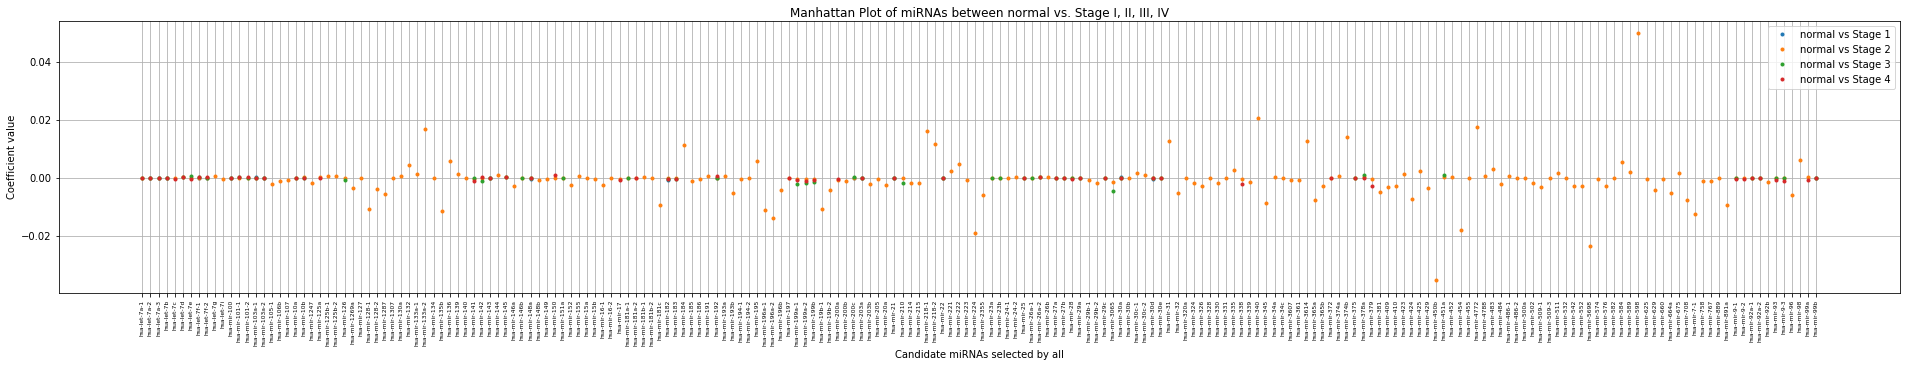

In [54]:
from matplotlib import pyplot as plt

all_candidate_miRNAs = set(results[0]['mirna']) | set(results[1]['mirna']) | set(results[2]['mirna']) | set(results[3]['mirna'])
sorted_candidate_miRNAs = []
for miR in mirna_list:
    if miR in all_candidate_miRNAs:
        sorted_candidate_miRNAs.append(miR)
print sorted_candidate_miRNAs.__len__()

plt.figure(figsize=(33, 5))
plt.xticks(range(sorted_candidate_miRNAs.__len__()), sorted_candidate_miRNAs, rotation='vertical', fontsize=6)

for i in [0,1,2,3]:
    x_indx = []
    y_values = []
    for x_str in results[i]['mirna']:
        # print all_candidate_miRNAs.index(x_str)
        x_indx.append(sorted_candidate_miRNAs.index(x_str))
    for y_value in results[i]['coefficient']:
        y_values.append(y_value)  
        
    # TODO add zeros values
        
    plt.plot(x_indx, y_values, marker='.', linestyle='', label='normal vs Stage '+str(i+1))

plt.legend()
plt.ylabel('Coefficient value')
plt.xlabel('Candidate miRNAs selected by all')
plt.title('Manhattan Plot of miRNAs between normal vs. Stage I, II, III, IV')
plt.axis('auto')
plt.grid(True)
plt.show()